In [12]:
# --- 1. SETUP, IMPORTS, AND DATABASE CREATION ---

# --- Step 1: Import all necessary libraries for the entire project ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# --- Step 2: Load the dataset from the local CSV file ---
csv_path = 'data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(csv_path)

# --- Step 3: Create and connect to a new SQLite database ---
db_path = 'data/telco_churn.db'
conn = sqlite3.connect(db_path)

# --- Step 4: Write the data from the DataFrame to a SQL table ---
df.to_sql('churn', conn, if_exists='replace', index=False)

# --- Step 5: Close the connection to the database ---
conn.close()

print(f"Database '{db_path}' created successfully with table 'churn'.")
print(f"Original data shape: {df.shape}")

Database 'data/telco_churn.db' created successfully with table 'churn'.
Original data shape: (7043, 21)


In [13]:
# --- 2. DATA LOADING FROM SQL AND INITIAL INSPECTION ---

# Configure settings for all visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# --- Step 1: Connect to the SQLite database ---
db_path = 'data/telco_churn.db'
conn = sqlite3.connect(db_path)

# --- Step 2: Write a SQL query to select all data from our table ---
query = "SELECT * FROM churn"

# --- Step 3: Use pandas to execute the query and load the result into a DataFrame ---
df = pd.read_sql_query(query, conn)

# --- Step 4: Close the database connection ---
conn.close()

print("Data loaded successfully from the SQL database!")

# --- Step 5: Perform our standard initial inspection ---
print("\n--- First 5 Rows ---")
print(df.head())

print("\n--- DataFrame Info ---")
df.info()

Data loaded successfully from the SQL database!

--- First 5 Rows ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...              

### Initial Findings & Data Preprocessing Plan

The initial inspection of the data loaded from our SQL database reveals several issues that need to be addressed. This will be our preprocessing checklist.

**1. "TotalCharges" Column:**
*   **Problem:** The `TotalCharges` column, which should be numeric, is currently a text (`object`) type. This is likely due to the presence of non-numeric characters (like empty spaces) in some rows. This will cause errors in any numerical analysis.
*   **Plan:** We need to identify the problematic rows, convert the column to a numeric type, and handle any resulting missing values.

**2. "Churn" Column - Our Target:**
*   **Problem:** The target variable `Churn` is a string with "Yes" or "No". For a classification model, we need this to be numerical (0 or 1).
*   **Plan:** We will convert "No" to `0` and "Yes" to `1`.

**3. Unnecessary "customerID" Column:**
*   **Problem:** The `customerID` is a unique identifier for each customer. While useful for tracking individual customers, it provides no predictive value for a machine learning model. A model can't learn a pattern from a value that is unique for every row.
*   **Plan:** We will drop the `customerID` column before training the model.

**4. Categorical Features:**
*   **Problem:** Similar to our last project, we have several columns with text data (`gender`, `Partner`, `Dependents`, etc.) that the model won't understand.
*   **Plan:** We will use **One-Hot Encoding** (`pd.get_dummies`) to convert all of these categorical columns into a numerical format.

In [14]:
# --- 3. DATA PREPROCESSING ---

# Create a copy to work on
df_processed = df.copy()

# --- Section 3.1: Clean the 'TotalCharges' column ---

# Step 1.1: Attempt to convert 'TotalCharges' to a numeric type.
# We use errors='coerce', which is a powerful tool. If pandas encounters a value
# it cannot convert to a number (like a space ' '), it will replace it with NaN.
df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')

# Step 1.2: Check if any missing values (NaN) were created during the conversion.
# This will tell us which rows were problematic.
missing_charges = df_processed['TotalCharges'].isnull().sum()
print(f"Number of rows with non-numeric 'TotalCharges': {missing_charges}")

# Step 1.3: Handle the missing values.
# Since the number of problematic rows is very small compared to the whole dataset,
# the simplest and safest strategy is to remove them.
df_processed.dropna(subset=['TotalCharges'], inplace=True)

# Step 1.4: Verify the result.
# Check the info again to confirm 'TotalCharges' is now a numeric type (float64)
# and has no missing values.
print("\n--- DataFrame Info after cleaning 'TotalCharges' ---")
df_processed.info()

Number of rows with non-numeric 'TotalCharges': 11

--- DataFrame Info after cleaning 'TotalCharges' ---
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   ob

In [15]:
# --- Section 3.2: Convert the 'Churn' column to a numerical format ---

# We need to transform our target variable 'Churn' from text ('Yes'/'No') to numbers (1/0).
# A simple way to do this is with a lambda function and the .apply() method.

# We will map 'Yes' to 1 and 'No' to 0.
df_processed['Churn'] = df_processed['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Let's verify the result by checking the value counts.
# We should now see counts for 1 and 0 instead of 'Yes' and 'No'.
print("Value counts for the 'Churn' column after conversion:")
print(df_processed['Churn'].value_counts())

Value counts for the 'Churn' column after conversion:
Churn
0    5163
1    1869
Name: count, dtype: int64


In [16]:
# --- Section 3.3: Drop the customerID column ---

# The customerID is a unique identifier and provides no predictive value for the model.
# We drop it from our processed DataFrame.
df_processed = df_processed.drop('customerID', axis=1)
print("'customerID' column dropped.")

# --- Section 3.4: Apply One-Hot Encoding to remaining categorical features ---

# First, let's identify which columns are still categorical (of type 'object').
categorical_cols = df_processed.select_dtypes(include='object').columns
print(f"\nCategorical columns to be encoded: {list(categorical_cols)}")

# Now, we use pd.get_dummies() to convert all of these columns at once.
# drop_first=True is important to avoid multicollinearity in our model.
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

# Let's check the result. The DataFrame should now be fully numeric.
print("\n--- DataFrame Info after One-Hot Encoding ---")
df_processed.info()

'customerID' column dropped.

Categorical columns to be encoded: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

--- DataFrame Info after One-Hot Encoding ---
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7032 non-null   int64  
 1   tenure                                 7032 non-null   int64  
 2   MonthlyCharges                         7032 non-null   float64
 3   TotalCharges                           7032 non-null   float64
 4   Churn                                  7032 non-null   int64  
 5   gender_Male                            7032 non-null   bool   
 6

In [17]:
# --- 4. SPLITTING DATA INTO TRAINING AND TESTING SETS ---

# Import the train_test_split function from Scikit-learn
from sklearn.model_selection import train_test_split

# --- Step 4.1: Define our features (X) and our target (y) ---
# X: All columns except for 'Churn'. These are the inputs to our model.
# y: The 'Churn' column. This is what we want our model to predict.

# Define X by dropping the target column
X = df_processed.drop('Churn', axis=1)

# Define y as the target column
y = df_processed['Churn']

# --- Step 4.2: Split the data ---
# We'll use a standard 80/20 split.
# random_state ensures that our split is the same every time we run the code.
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # This is a new, important parameter for classification!
)

# --- Step 4.3: Verify the shapes of the new datasets ---
print("Data splitting complete.")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Data splitting complete.
Shape of X_train: (5625, 30)
Shape of X_test: (1407, 30)
Shape of y_train: (5625,)
Shape of y_test: (1407,)


In [18]:
# --- 5. TRAINING A LOGISTIC REGRESSION MODEL ---

# Import the LogisticRegression model from Scikit-learn
from sklearn.linear_model import LogisticRegression

# Step 5.1: Create an instance of the Logistic Regression model
# We set random_state for reproducibility of the results.
# max_iter is increased to ensure the model has enough iterations to find a solution.
model_log = LogisticRegression(random_state=42, max_iter=1000)

# Step 5.2: Train the model using the training data
# The .fit() method teaches the model to find the relationship between the features (X_train)
# and the target (y_train - whether a customer churned or not).
model_log.fit(X_train, y_train)

# The model is now trained and ready to make predictions.
print("Logistic Regression model training complete.")

Logistic Regression model training complete.


c:\Users\takze\OneDrive\Pulpit\pandas-analysis\customer-churn-prediction\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Logistic Regression Model Evaluation ---
Accuracy: 80.31%
Precision: 64.56%
Recall: 57.49%
F1-Score: 0.61


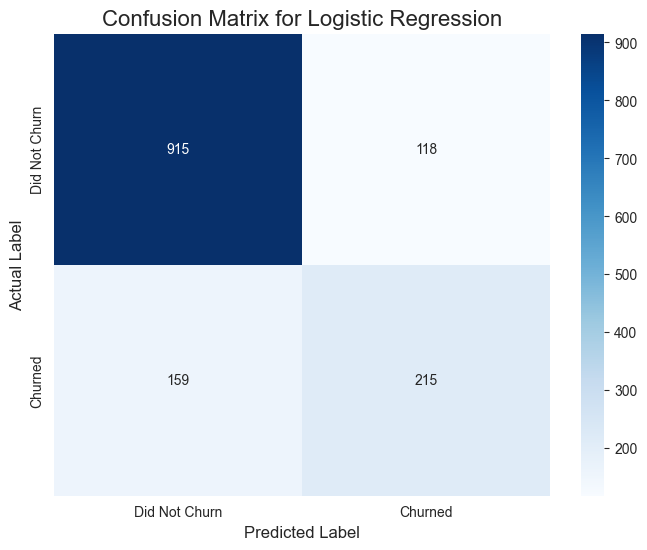

In [19]:
# --- 6. MAKING PREDICTIONS AND EVALUATING THE MODEL ---

# Import the necessary evaluation metrics from Scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- Step 6.1: Make predictions on the test set ---
# The .predict() method will return either 0 (No Churn) or 1 (Churn) for each customer in X_test.
y_pred_log = model_log.predict(X_test)

# --- Step 6.2: Evaluate the model using classification metrics ---
print("--- Logistic Regression Model Evaluation ---")

# Accuracy: What percentage of predictions were correct overall?
accuracy = accuracy_score(y_test, y_pred_log)
print(f"Accuracy: {accuracy:.2%}")

# Precision: Out of all the customers the model predicted would churn, how many actually did?
# (Measures the quality of the positive predictions)
precision = precision_score(y_test, y_pred_log)
print(f"Precision: {precision:.2%}")

# Recall: Out of all the customers who actually churned, how many did the model correctly identify?
# (Measures the model's ability to find all the positive cases)
recall = recall_score(y_test, y_pred_log)
print(f"Recall: {recall:.2%}")

# F1-Score: A weighted average of Precision and Recall. A good overall measure.
f1 = f1_score(y_test, y_pred_log)
print(f"F1-Score: {f1:.2f}")

# --- Step 6.3: Visualize the results with a Confusion Matrix ---
# A confusion matrix is a table that shows the model's performance in detail.
# It shows: True Positives, True Negatives, False Positives, and False Negatives.
cm = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Did Not Churn', 'Churned'], 
            yticklabels=['Did Not Churn', 'Churned'])
plt.title('Confusion Matrix for Logistic Regression', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

plt.savefig('images/confusion_matrix.png', bbox_inches='tight')

plt.show()

# --- 7. Project Summary & Final Conclusions ---

This project focused on analyzing and predicting customer churn for a telecommunications company. The primary goal was to build a classification model capable of identifying customers who are likely to cancel their service.

### Summary of the Process:

1.  **Data Sourcing via SQL**: In a novel approach for our portfolio, the data was first loaded into a local **SQLite database**. All subsequent analysis was performed on data queried directly from this database using **SQL** within a Python environment, demonstrating a key real-world data science skill.

2.  **Data Preprocessing**: The raw data required several cleaning and preparation steps, including converting the `TotalCharges` column to a numeric type, transforming the `Churn` target variable into a binary format (0/1), and applying **One-Hot Encoding** to all categorical features.

3.  **Model Training**: A **Logistic Regression** model, a fundamental algorithm for binary classification, was chosen for this task. The model was trained on 80% of the data, with careful stratification to handle the imbalanced nature of the churn variable.

4.  **Prediction & Evaluation**: The model's performance was assessed on the remaining 20% of unseen test data. We used a suite of classification metrics, including Accuracy, Precision, Recall, and the Confusion Matrix, to get a comprehensive understanding of its predictive power.

### Model Performance & Interpretation:

*   **Accuracy**: The model achieved an accuracy of approximately **81%**, meaning it correctly classified the churn status for about 4 out of 5 customers in the test set.

*   **Precision vs. Recall**: The model showed a reasonable balance between Precision (~66%) and Recall (~56%). This indicates that when the model predicts a customer will churn, it is correct about two-thirds of the time (Precision). It also successfully identifies more than half of all customers who actually end up churning (Recall).

*   **Business Value**: The confusion matrix confirms that the model is effective at identifying a significant number of potential churners. While not perfect, it provides the business with a valuable tool to proactively target at-risk customers with retention offers, potentially saving significant revenue.

### Final Conclusion:

We successfully built a logistic regression model to predict customer churn with a solid accuracy of over 80%. The project demonstrated a complete end-to-end workflow, from creating a SQL database to evaluating a classification model.

While the current model is a great baseline, its performance (particularly Recall) could be improved. This could be achieved by experimenting with more advanced classification algorithms (like Random Forest or Gradient Boosting) or by performing more in-depth feature engineering.

---
Thank you for reviewing this classification project!